<h1 align="center">The Centroid and PCA Method Applied to Digit Recognition</h1>
<h2 align="center">Quan Li</h2>

<h2>Part 1 SQL Query by Nicholas Alonzo</h2>

In [ ]:
import pandas as pd
import sqlite3 as sql

db = sql.connect('github.db')
c = db.cursor()

In [99]:
# This query finds all the issue ids where there was an opening and closing action for the 
# issue itself. It then inserts the results into a temporary table QUERY1 for later use.
# NOTE: 
# 1. It's likely that some issues will be reopened and then closed again
# 2. For some reason not all issues will be in the DB, perhaps due to pre-processing error?

QUERY1 = '''
CREATE TEMP TABLE QUERY1 AS 
SELECT issue_id
  FROM (
           SELECT repo_id,
                  issue_id,
                  [action]
             FROM issues_events
            WHERE [action] = 'opened'
           UNION
           SELECT repo_id,
                  issue_id,
                  [action]
             FROM issues_events
            WHERE [action] = 'closed'
       )
       AS R1
 WHERE repo_id IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       )
 GROUP BY repo_id,
          issue_id
HAVING COUNT( * ) = 2;
'''
c.execute(QUERY1)

In [100]:
# This query uses the QUERY1 results to select the number of times that issue appeared MOD 2 = 0
# and inserts the results into a temporary table QUERY2 for later use. Since the only actions in 
# this table are 'opened', 'closed', and 'reopened'. MOD 2 = 0 means there was a pair of opening
# and closing actions that occured.

QUERY2 =  '''
CREATE TEMP TABLE QUERY2 AS
SELECT issue_id
  FROM issues_events
 WHERE issue_id IN (SELECT issue_id FROM [temp].QUERY1)
 GROUP BY repo_id,
          issue_id
HAVING COUNT( * ) % 2 = 0;
'''
c.execute(QUERY2)

In [101]:
# This query uses the QUERY2 results to select the date the issue was FIRST OPENED and
# inserts the results into a temporary table DT_OPENED for later use.

DT_OPENED = '''
CREATE TEMP TABLE DT_OPENED AS
SELECT repo_id,
       issue_id,
       issue_number,
       title AS opened_title,
       MIN(date_created) AS exact_date_opened
  FROM issues_events
 WHERE issue_id IN (SELECT issue_id FROM [temp].QUERY2)
 GROUP BY repo_id,
          issue_id,
          issue_number;
'''
c.execute(DT_OPENED)

In [102]:
# This query uses the QUERY2 results to select the date the issue was LAST CLOSED and
# inserts the results into a temporary table DT_CLOSED for later use.

DT_CLOSED = '''
CREATE TEMP TABLE DT_CLOSED AS
SELECT repo_id,
       issue_id,
       issue_number,
       title AS closed_title,
       MAX(date_created) AS exact_date_closed
  FROM issues_events
 WHERE issue_id IN (SELECT issue_id FROM [temp].QUERY2)
 GROUP BY repo_id,
          issue_id,
          issue_number;
'''
c.execute(DT_CLOSED)

In [103]:
issue_query = '''
SELECT o.*, 
       c.closed_title,
       c.exact_date_closed,
       ROUND(ABS(julianday(o.exact_date_opened) - julianday(c.exact_date_closed) ), 2) AS exact_date_diff
  FROM [temp].DT_OPENED AS o
       LEFT JOIN
       [temp].DT_CLOSED AS c ON (o.repo_id = c.repo_id AND 
                                 o.issue_id = c.issue_id) 
 ORDER BY o.repo_id,
          o.issue_number;
'''
issues = pd.read_sql(issue_query, db)

In [147]:
issue_query = '''
SELECT o.*, 
       c.closed_title,
       c.exact_date_closed,
       SUM(ROUND(ABS(julianday(o.exact_date_opened) - julianday(c.exact_date_closed) ), 2)) AS exact_date_diff
  FROM [temp].DT_OPENED AS o
       LEFT JOIN
       [temp].DT_CLOSED AS c ON (o.repo_id = c.repo_id AND 
                                 o.issue_id = c.issue_id) 
 ORDER BY o.repo_id,
          o.issue_number;
'''
issues = pd.read_sql(issue_query, db)

In [16]:
# Now we can use the issues DataFrame to do parameterized queries to get 
# the number of forks occuring between the issue periods for each repo.

DFs = []
for idx, row in issues.iterrows():
    
    query = '''
    SELECT repo_id, issue_id, date_created, comment, user_id, user_login
      FROM issue_comment_events
     WHERE repo_id = :repo_id AND 
           issue_id = :issue_id AND
           date_created <= :dt_closed;
    '''
    result = pd.read_sql(query, db, params={'repo_id': row.repo_id,
                                            'issue_id': row.issue_id,
                                            'dt_closed': row.exact_date_closed})
    DFs.append(result)

comments = pd.concat(DFs, axis=0, ignore_index=True)

In [17]:
issues_comments = pd.merge(issues, comments, how='inner', on=['repo_id', 'issue_id'])

In [68]:
# Drop the temporary tables
c.executescript('''
DROP TABLE [temp].QUERY1; 
DROP TABLE [temp].QUERY2;
DROP TABLE [temp].DT_OPENED;
DROP TABLE [temp].DT_CLOSED;
''')
db.commit()

<h2>Part 2 Issue Title Context Change Analysis</h2>

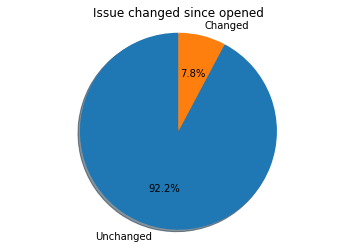

In [127]:
tmp=[issues['opened_title']==issues['closed_title']]
acc=sum(tmp[0])/len(tmp[0])
1-acc
labels = ['Unchanged','Changed']
sizes = [acc, 1-acc]
plt.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')
plt.title("Issue changed since opened")
plt.show()

<h2>Part 3 Issue Close Efficiency Analysis </h2>

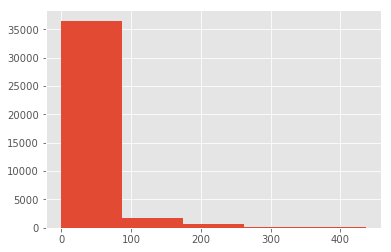

In [87]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
plt.hist(issues_comments['exact_date_diff'], bins=5, label='Date diff')
plt.show()

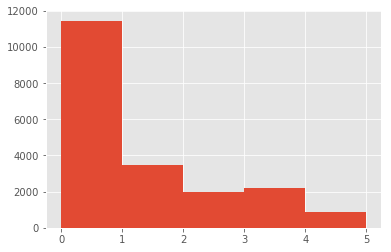

In [89]:
tmp=issues_comments.loc[issues_comments['exact_date_diff']<5]
plt.hist(tmp['exact_date_diff'], bins=5, label='Date diff')
plt.show()

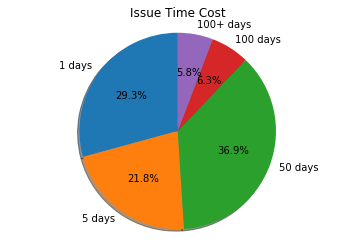

In [128]:
tmp=issues_comments.loc[issues_comments['exact_date_diff']<1]
d1=tmp.shape[0]/issues_comments.shape[0]
tmp=issues_comments.loc[issues_comments['exact_date_diff']<5]
d5=tmp.shape[0]/issues_comments.shape[0]
tmp=issues_comments.loc[issues_comments['exact_date_diff']<50]
d50=tmp.shape[0]/issues_comments.shape[0]
tmp=issues_comments.loc[issues_comments['exact_date_diff']<100]
d100=tmp.shape[0]/issues_comments.shape[0]

labels = ['1 days','5 days', '50 days','100 days','100+ days']
sizes = [d1,d5-d1,d50-d5,d100-d50,1-d100]
plt.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')
plt.title("Issue Time Cost")
plt.show()

<b>obviously, Group by date diff does not make any sense. Try group by action(open and close). It seems most of issues open and close at the same day.</b>

<h2>Part 4 Nonnegative Matrix Factorization Analysis</h2>

In [24]:
import numpy as np
from nltk import corpus
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

def display_topics(model, feature_names):
    for i, topic in enumerate(model.components_):
        print("Topic %d:" % (i))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-11 - 1:-1]]))
        
def lemmatize(text, stop=0):
    """
    Tokenization, and Stemming
    Input: text(string need to be cleaned), 
    Output: a tokenized, and stemmed list of words 
    """
    #Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text.lower())
    if stop==1:
        stopped = [word for word in tokens if word not in stopwords.words('english')]
    else:
        stopped=tokens
    #Stemming
    stemmer = PorterStemmer().stem
    return [stemmer(w.lower()) for w in stopped]

#vectorizition
tfidf_vectorizer=TfidfVectorizer(tokenizer=lemmatize,stop_words="english",smooth_idf=True, norm=None)
texts=issues_comments['comment'].tolist()
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
0 1 tgz yarnpkg registri 2 resolv babel 3 6 version
Topic 1:
08 active_pokemon_id search_worker_0 168 retri tabl pokestop column 23 warn 13
Topic 2:
19116 19147 breventserv 03 10 15 d com android tencent 13
Topic 3:
7 framework __getitem__ python ctype self cellar __init__ python2 2 usr
Topic 4:
s0 u c768 c512 scontext tcontext tclass avc object_r comm ino
Topic 5:
03 02 1052 13 47 14157 0 48 android 4187 com
Topic 6:
6208 breventserv 29 03 15 d 44 45 com android ele
Topic 7:
9172 9204 breventserv 03 15 10 47 com d v 48
Topic 8:
3d 0a 20 3b 3a 3anth 2f 20li 0aul 20background 20color
Topic 9:
04 breventserv 03 androidruntim d java 17 e 19 01 16787


In [62]:
query="""SELECT action,
       title,
       description,
       MIN(date_created) AS exact_date_opened
FROM issues_events
GROUP BY repo_id,
        issue_id,
        issue_number;"""

#query = "SELECT action, title,description, FROM issues_events"
issue_comments_2 = pd.read_sql(query, db)
issue_comments_2=issue_comments_2.drop_duplicates(subset='title',keep='last')
issue_comments_2=issue_comments_2.dropna(axis=0)
issue_comments_2['comment']=issue_comments_2['title']+issue_comments_2['description']
issue_comments_opened=issue_comments_2.loc[issue_comments_2['action'] == 'opened']['title'].tolist()
issue_comments_closed=issue_comments_2.loc[issue_comments_2['action'] == 'closed']['title'].tolist()
issue_comments_opened_description=issue_comments_2.loc[issue_comments_2['action'] == 'opened']['description'].tolist()
issue_comments_closed_description=issue_comments_2.loc[issue_comments_2['action'] == 'closed']['description'].tolist()
issue_comments_reopened=issue_comments_2.loc[issue_comments_2['action'] == 'reopened']['title'].tolist()
issue_comments_reopened_description=issue_comments_2.loc[issue_comments_2['action'] == 'reopened']['description'].tolist()

In [54]:
texts=issue_comments_opened
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
0 1 2 9 3 4 version 7 5 downgrad 6
Topic 1:
t doesn don isn updat won input load aren instal zappa
Topic 2:
error build messag pars compil javascript object thi load modul undefin
Topic 3:
add support option link type suggest new enhanc custom command abil
Topic 4:
file mix js css path compil download sass version directori onli
Topic 5:
use valid instead thi data chang input node api s select
Topic 6:
notif app io android receiv background crash push foreground icon fcm
Topic 7:
request featur scan chang type locat pokemon pull multipl option set
Topic 8:
work doe map exampl valid properli doesn doesnt locat mix onli
Topic 9:
run npm fail instal dev build issu pipenv product window hot


It shows version downgrad is one of the top reason for issue opened action

In [55]:
texts=issue_comments_closed
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
0 2 3 1 sinc broken 10 window build 9 whi
Topic 1:
block mode class syntaxerror outsid declar strict scope const function npm
Topic 2:
add serial test entir delet backspac abil ctrl html line transform
Topic 3:
leaf data key text render forc offset chang work error push
Topic 4:
node use sass support express seper webpack environ current doe server
Topic 5:
request page sometim t set transpar fab bar isn nav inset
Topic 6:
transform creat new allow state don focu t snapshot save instanc
Topic 7:
mix ani way file laravel js parti transpil let tutori 5
Topic 8:
uninstal dev end compil process use watch automat poll run pipenv
Topic 9:
http locat post zeep wsdl despit updat a9lh fbi inject bug


<b>Document Classification Method: Nonnegative matrix factorization (NMF)
"Nonnegative matrix factorization (NMF) has become a widely used tool for the analysis of high-dimensional data as it automatically extracts sparse and meaningful features from a set of nonnegative data vectors."

Top potential reason based on top interpretable factors 
1. version problem, add new files, downgrade to fix
2. relative sources issue, such as operation system 
3. syntax error
4. environment support problem
5. cross Platform 
</b>

In [130]:
texts=issue_comments_opened_description
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
vid squirrel boolean sebastian string task int32 08 2016 appdata applyreleasesimpl
Topic 1:
gt lt 0 bitrat esinfo inputid id codec aurat input avsyncdelay
Topic 2:
androidruntim 02 java e android 24 25 brevent 17 22 lang
Topic 3:
04 f debug 11 pc 10 linker androidruntim bin java e
Topic 4:
13848 breventserv 05 19 18 brevent d 31793 29492 31659 check
Topic 5:
02 17 15 42 525 6725 41 mm 1870 camera e
Topic 6:
boolean 08 string squirrel 2016 applyreleasesimpl io int32 appdata checkhost task
Topic 7:
5030 breventserv 03 d 22 20 com 7812 329 android 24
Topic 8:
breakpad 15300 14996 04 16 13 00000000 56 42 f googl
Topic 9:
0 demot post_frequ android mute user_id pkg 23 4 1 count


In [131]:
texts=issue_comments_closed_description
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
unhandl byte esc_dispatch b int 40 param 42 osc_put h osc_start
Topic 1:
git alacritti pacaur solaraquarion dep rlib extern target releas home cach
Topic 2:
my_usernam miniconda3 virtualenv user python3 line py pew lib file 6
Topic 3:
app appdata pokescan pokemon resourc zip c py local line user
Topic 4:
rs buildslav buildbot slave src nightli rustc linux dist rust panick
Topic 5:
js draft facebook blob master compon github com src http select
Topic 6:
py aakhochar tensorflow home line vgg16_default anchor_default lib python2 tensorflowr10 dt_int32
Topic 7:
ecampu 0 verbos 1 lifecycl error dev usr 23 npm 14
Topic 8:
loader webpack css __dirnam path app sass public js vue style
Topic 9:
ns0 customerdata addressdata zeep soap clientcontext client wsdl addnewcustom nl citi


<h2>Part 5 Inverse Document Frequency Analysis</h2>

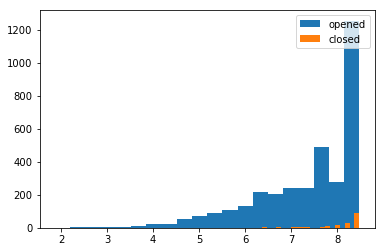

In [57]:
from matplotlib import pyplot as plt
def text_dictionary(texts):
    textd={}
    for text in texts:
        #t=corpus.reuters.raw(text)
        s =set(lemmatize(text))
        try:
            toks=toks|s
        except NameError:
            toks=s
        for tok in s:
            try:
                textd[tok].append(text)
            except KeyError:
                    textd[tok]=[text]
    tok_list=list(toks)
    return [textd,tok_list]

def idf_smooth(texts):
    textd=text_dictionary(texts)[0]
    numd={key:len(set(val)) for key,val in textd.items()}
    logN=np.log(len(issue_comments_2['title']))
    return {key:logN-np.log(1+val) for key,val in numd.items() if val>1}

idf_smooth_opened=idf_smooth(issue_comments_opened)
idf_smooth_closed=idf_smooth(issue_comments_closed)

plt.hist(list(idf_smooth_opened.values()), bins=20, label='opened')
plt.hist(list(idf_smooth_closed.values()), bins=20,label='closed')
plt.legend(loc='upper right')
plt.show()

From above plot, we can know that the opened titles are typically cover the same content as colsed title.

<h2>Part 6 Word Cloud Analysis</h2>

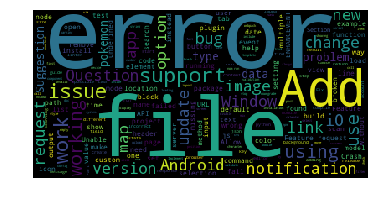

In [33]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(" ".join(issue_comments_opened))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

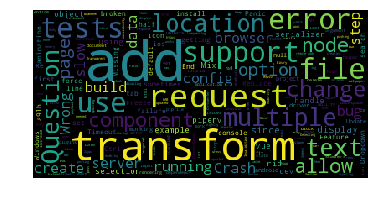

In [58]:
wordcloud = WordCloud().generate(" ".join(issue_comments_closed))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Word clouds also show the contents similarity between opened and colsed title

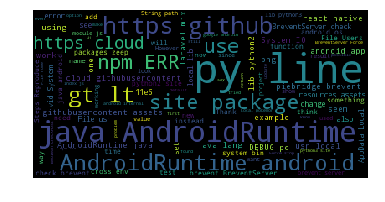

In [38]:
wordcloud = WordCloud().generate(" ".join(issue_comments_opened_description))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

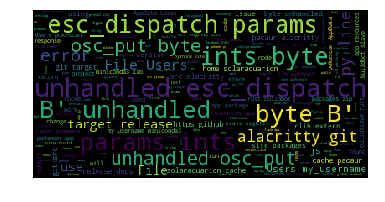

In [60]:
wordcloud = WordCloud().generate(" ".join(issue_comments_closed_description))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [139]:
pr_df=pd.read_csv("pr_issues.csv")
pr_df=pr_df.dropna(axis=0)
pull_request_title=pr_df['pull_request_title'].tolist()
pull_request_description=pr_df['pull_request_description'].tolist()
issue_title=pr_df['issue_title'].tolist()
issue_description=pr_df['issue_description'].tolist()

In [140]:
texts=pull_request_title
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
output handl tti color complet work 8 invalid utf miss rm
Topic 1:
fix inlin void bug node page function render header posit comput
Topic 2:
parent blame link ad remov github featur ha line specif repeat
Topic 3:
add support test linter text option abil improv handler factor pep8
Topic 4:
0 1 messag match error serverless xxx pars project tab subcategori
Topic 5:
make possibl 3 lxml x etre 5 cleanup_namespac promis overrid bluebird
Topic 6:
devic enhanc config statu queri support file feed featur feat faster
Topic 7:
use font path code enabl custom ligatur editor refer algorithm rewritten
Topic 8:
file button copi link pr diff content view singl raw delet
Topic 9:
resolv pars prevent payload 177 hapi app type variabl valu transform


In [141]:
texts=issue_title
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
link blame parent specif line branch longer duplic delet point commit
Topic 1:
add support type request featur array pars gener lint ansibl function
Topic 2:
reduc make prevent confus easier swap whi redux revers tradit paramet
Topic 3:
t doesn work expect window non color exampl getblock imag git
Topic 4:
chang diff new github reaction avatar fix header filenam view sticki
Topic 5:
button unread remov notif mark clear read comment box icon repli
Topic 6:
use merg object assign chang onli classnam deep e disallow arrow
Topic 7:
posit popper incorrect placement absolut insid rel flip parent refer unexpect
Topic 8:
file search ripgrep caus directori redirect rg error switch flag doe
Topic 9:
page torrent access id bit tri 32 blank yield integ limit


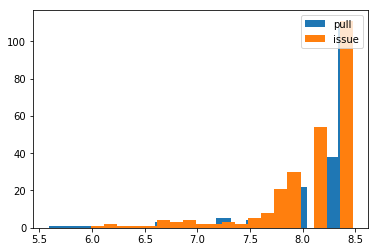

In [142]:
idf_smooth_opened=idf_smooth(pull_request_title)
idf_smooth_closed=idf_smooth(issue_title)

plt.hist(list(idf_smooth_opened.values()), bins=20, label='pull')
plt.hist(list(idf_smooth_closed.values()), bins=20,label='issue')
plt.legend(loc='upper right')
plt.show()

In [143]:
texts=pull_request_description
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
x node normal transform schema inlin text core key document test
Topic 1:
utf encod 8 thi 16 search transcod text ripgrep memori map
Topic 2:
x gain save hackrf send fix rtl baseband recv paramet dialog
Topic 3:
color line provid fix tti magenta yellow wincolor termcolor termin crate
Topic 4:
kbd search arrow modal select result input follow tab furthermor 229
Topic 5:
notif mark page extens 2 icon 08 read render alt img
Topic 6:
zappa egg virtualenv packag actual github zip xxxxxxx clone miserl file
Topic 7:
x analysi signal preview accept allow view data select window caption
Topic 8:
popup keyboard open shown popupwindow variant better calcul click height dialog
Topic 9:
gitbook book slate com thi http prism domain repositori sinc support


In [144]:
texts=issue_description
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
ale trygv home dev js bin let test 2 eslint g
Topic 1:
txt hello tmp2 tmp tmp3 yellow found2 rg temp 1 temp2
Topic 2:
snr null error code 45_handleexitneovim 45_handleexit handle_rustc_error rustc rust ale_lint 1
Topic 3:
sourceri homebrew valuetyp rb usr local librari test formula swift path
Topic 4:
python3 6 usr virtualenv site packag lib py pip line numpi
Topic 5:
client tooltip 33 js 27 15 1 0 webpack popper dist
Topic 6:
stori joscha canva web js build dev target user 30 flyout
Topic 7:
xs flagdetailsstruct soap wsdl env valu element sequenc nsp complextyp restrict
Topic 8:
copyright psd1 corpor reserv microsoft appbackgroundtask c right 0 v1 assignedaccess
Topic 9:
pipenv python2 pipfil packag site py 7 lib self usr local


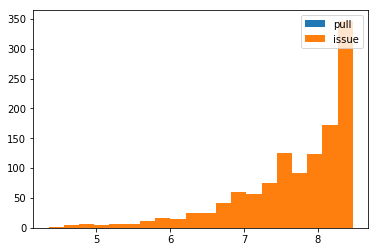

In [145]:
idf_smooth_opened=idf_smooth(pull_request_description)
idf_smooth_closed=idf_smooth(issue_description)

plt.hist(list(idf_smooth_opened.values()), bins=20, label='pull')
plt.hist(list(idf_smooth_closed.values()), bins=20,label='issue')
plt.legend(loc='upper right')
plt.show()

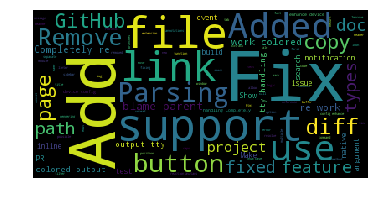

In [148]:
wordcloud = WordCloud().generate(" ".join(pull_request_title))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

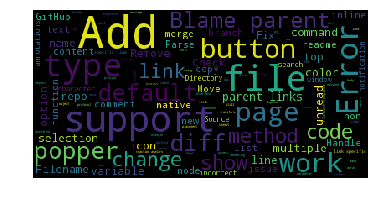

In [149]:
wordcloud = WordCloud().generate(" ".join(issue_title))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

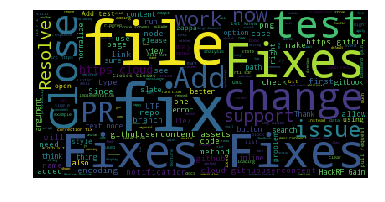

In [150]:
wordcloud = WordCloud().generate(" ".join(pull_request_description))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

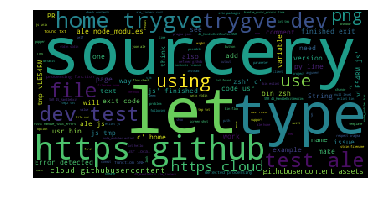

In [151]:
wordcloud = WordCloud().generate(" ".join(issue_description))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

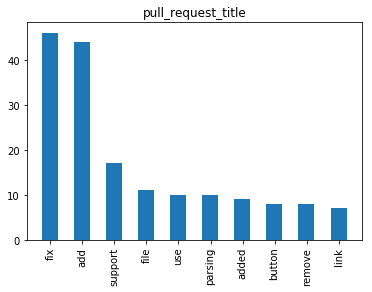

In [188]:
from collections import Counter

pull_request_title = str(pull_request_title).lower().translate({ord(c): " " for c in "?,!.()'\":"}).replace("-", "")
tokens=pull_request_title.split()
stopped = [word for word in tokens if word not in stopwords.words('english')]
labels, values=zip(*Counter(stopped).most_common(100)[:10])
indexes = np.arange(len(labels))
width = 0.5
plt.bar(indexes, values, width)
plt.xticks(indexes + width*0.01, labels,rotation='vertical')
plt.title("pull_request_title")
plt.show()

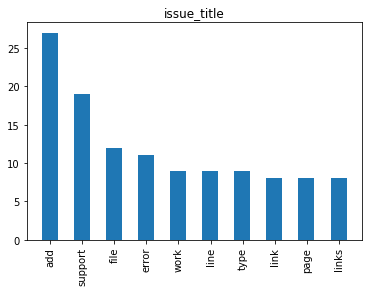

In [190]:
issue_title = str(issue_title).lower().translate({ord(c): " " for c in "?,!.()'\":"}).replace("-", "")
tokens=issue_title.split()
stopped = [word for word in tokens if word not in stopwords.words('english')]
labels, values=zip(*Counter(stopped).most_common(100)[:10])
indexes = np.arange(len(labels))
width = 0.5
plt.bar(indexes, values, width)
plt.xticks(indexes + width*0.01, labels,rotation='vertical')
plt.title("issue_title")
plt.show()